# HW 1 
## Homework 1 for SOCS course 
### Viggo Wessner 

#### **Exercise 1. Brownian disk with Lennard Jones potential**
Simulate a Brownian disk (see Fig. 1.8 in the book). Start with a single disk (radius Rdisk, mass mdisk) and
N 2
part particles (point-like, mass m). The particles do not mutually interact. The interaction happens only
among the disk and the particles through a Lennard-Jones potential (parameters: σ = 1, $\epsilon$ = 1).
The system is enclosed in a squared box with reflecting boundaries. The size of the box is L × L. Initially, the
particles are positioned on a squared lattice. They have a velocity with random orientation and magnitude v.
The disk start from the center of the box from rest (i.e., its velocity is 0). In the simulation, use the following
parameters:
##### **P1** - trajectory of the disk in the Cartesian plane.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

sigma = 1
eps = 1


m_p = 1
v0_p = 10
N_p = 25

m_d = 10
R_d = 10
vx_d = 0
vy_d = 0
L = 260

T = 400
dt = 0.005


x_min, x_max, y_min, y_max = -L/2, L/2, -L/2, L/2





# Generate initial positions on a grid and orientations at random.
x0, y0 = np.meshgrid(
    np.linspace(- L / 2, L / 2, int(np.ceil(np.sqrt(N_p)))),
    np.linspace(- L / 2, L / 2, int(np.ceil(np.sqrt(N_p)))),
)
x0 = x0.flatten()[:N_p]
y0 = y0.flatten()[:N_p]
phi0 = (2 * np.random.rand(N_p) - 1) * np.pi


# Filter out particles within 3σ of disk rim
filtered_indices = []
for i in range(N_p):
    r = np.sqrt((x_d - x0[i])**2 + (y_d - y0[i])**2)
    if r >= R_d + 3 * sigma:
        filtered_indices.append(i)

# Initialize the variables for the leapfrog algorithm.
# Current time srep.
N_p = len(filtered_indices)

x_d = 0
y_d = 0
x_d_half = 0
y_d_half = 0
x = x0[filtered_indices]
y = y0[filtered_indices]
x_half = np.zeros(N_p)
y_half = np.zeros(N_p)
v = v0_p
phi = phi0[filtered_indices]
vx = v0_p * np.cos(phi)
vy = v0_p* np.sin(phi)

# Next time step.
nx_d = 0
ny_d = 0
nvx_d = 0
nvy_d = 0
nx = np.zeros(N_p)
ny = np.zeros(N_p)
nv = np.zeros(N_p)
nphi = np.zeros(N_p)
nvx = np.zeros(N_p)
nvy = np.zeros(N_p)




def lennard_jones_force(r):
    """Calculate Lennard-Jones force."""
    if r <= 0:
        return 0
    return 24 * (eps/r) * ((2 * (sigma / r)**12) - ((sigma / r)**6)) 



def total_force(x,y, x_d, y_d, N_p):
    """
    Calculate the total Lennard-Jones force on the disk from all particles.

    Returns:
        Fx: Total force in x-direction on the disk
        Fy: Total force in y-direction on the disk
        Fx_p: Array of forces in x-direction on each particle
        Fy_p: Array of forces in y-direction on each particle
    """
    Fx = 0
    Fy = 0
    Fx_p = np.zeros(N_p)
    Fy_p = np.zeros(N_p)

    for i in range(N_p):
        dx = x_d - x[i]
        dy = y_d - y[i]
        distance = np.sqrt(dx**2 + dy**2)
        r = distance - R_d
        if r > 0:
            F = lennard_jones_force(r)
            Fx_component = F * (dx) / distance
            Fy_component = F * (dy) / distance
            Fx += Fx_component
            Fy += Fy_component
            Fx_p[i] -= Fx_component
            Fy_p[i] -= Fy_component

    return Fx, Fy, Fx_p, Fy_p



disc_velocities = []
disc_positions = []
num_steps = int(T / dt)
for step in range(num_steps):
    #Half step stuff for leapfrog
    x_half = x + 0.5*vx*dt
    y_half = y + 0.5*vy*dt

    x_d_half = x_d + 0.5*vx_d*dt
    y_d_half = y_d + 0.5*vy_d*dt

    fx, fy, fx_p, fy_p = total_force(x_half, y_half, x_d_half, y_d_half, N_p)
#Disc stuff
    nvx_d = vx_d + (fx/m_d) * dt
    nvy_d = vy_d + (fy/m_d) * dt

    nx_d = x_d + + 0.5*nvx_d*dt
    ny_d = y_d + 0.5*nvy_d*dt

#Particle stuff

    nvx = vx + (fx_p / m_p) * dt
    nvy = vy + (fy_p / m_p) * dt

    nx = x_half + 0.5 * nvx * dt
    ny = y_half + 0.5 * nvy * dt


    
    #Reflect boundary conditions for particles and check if touch disc
    for j in range(N_p):
        if nx[j] < x_min:
            nx[j] = x_min + (x_min - nx[j])
            nvx[j] = - nvx[j]

        if nx[j] > x_max:
            nx[j] = x_max - (nx[j] - x_max)
            nvx[j] = - nvx[j]

        if ny[j] < y_min:
            ny[j] = y_min + (y_min - ny[j])
            nvy[j] = - nvy[j]
            
        if ny[j] > y_max:
            ny[j] = y_max - (ny[j] - y_max)
            nvy[j] = - nvy[j]
        

    # Reflect disc at boundaries
        if (nx_d - R_d < x_min) or (nx_d + R_d > x_max):
            nvx_d = -nvx_d
        # Adjust position to lie within boundaries
        if nx_d - R_d < x_min:
            nx_d = x_min + R_d
        if nx_d + R_d > x_max:
            nx_d = x_max - R_d

        if (ny_d - R_d < y_min) or (ny_d + R_d > y_max):
            nvy_d = -nvy_d
        # Adjust position to lie within boundaries
        if ny_d - R_d < y_min:
            ny_d = y_min + R_d
        if ny_d + R_d > y_max:
            ny_d = y_max - R_d


    #Store disc pos
    disc_positions.append((x_d, y_d))
    disc_velocities.append((vx_d, vy_d))

    # Update variables for next iteration
    x = nx
    y = ny
    vx = nvx
    vy = nvy
    x_d = nx_d
    y_d = ny_d
    vx_d = nvx_d
    vy_d = nvy_d

disc_positions = np.array(disc_positions)

# Plot P1: Trajectory of the disk
plt.figure(figsize=(6, 6))
plt.plot(disc_positions[:, 0], disc_positions[:, 1], label="Disk Trajectory")
plt.plot(disc_positions[0,0], disc_positions[0,1], "-o")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Trajectory of the Disk")
plt.legend()
plt.grid(True)
plt.axis('equal')  # Ensure equal scaling on both axes
plt.show()


NameError: name 'x_d' is not defined

##### **P2** - plot MSD as a function of time $t=n\Delta t$, calculated as: $$MSD(n\Delta t) =\frac{1}{N-n}\sum_{i=1}^{N-n}(X_{i+n}- X_i)^2 + (Y_{i+n} - Y_i)^2$$

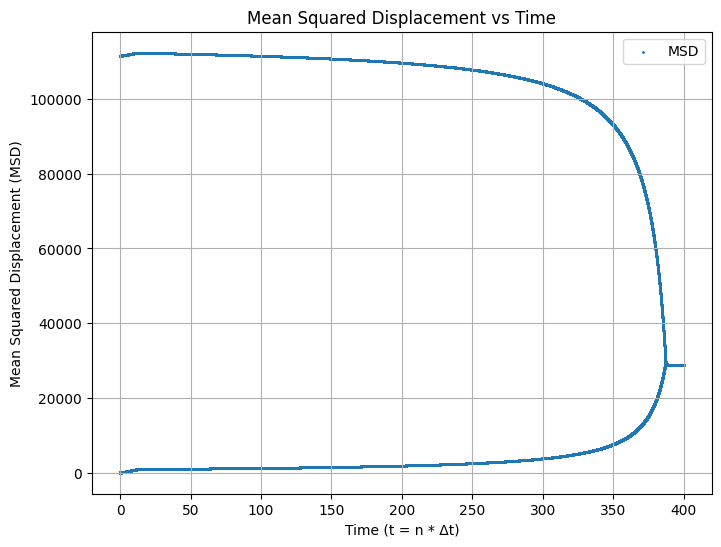

In [ ]:

def MSD(disc_positions):
    N = len(disc_positions)  # Total number of time steps
    msd = np.zeros(N - 1)    # We only need N-1 steps for MSD

    # Loop over lag times (n)
    for n in range(1, N):
        # Calculate squared displacements for each lag time `n`
        dx = disc_positions[n:, 0] - disc_positions[:N-n, 0]  # Displacement in x
        dy = disc_positions[n:, 1] - disc_positions[:N-n, 1]  # Displacement in y
        squared_displacement = dx**2 + dy**2
        msd[n - 1] = (np.sum(squared_displacement))/ (N-n)           # Mean of squared displacements

    return msd


msd_values = MSD(disc_positions)
msd_times = np.arange(1, len(msd_values) + 1) * dt


plt.figure(figsize=(8, 6))
plt.scatter(msd_times, msd_values, s=1, label='MSD' )
plt.xlabel('Time (t = n * Δt)')
plt.ylabel('Mean Squared Displacement (MSD)')
plt.title('Mean Squared Displacement vs Time')
plt.legend()
plt.grid()
plt.show()

        

#### **Exercise 2. Magnetic susceptibility of the 2-d Ising model**
**Task 1.** In this task we show that the 2D Ising model behaves like a paramagnetic material at temperatures
T higher than its critical temperature (e.g., $T > T_c ≈ 2.269$).
Set $T = 5$. Calculate the total magnetization of the system as a function of H. We suggest you to use
the following values for $H$:
$H = −5, −2, −1, −0.5, −0.2, −0.1, 0, 0.1, 0.2, 0.5, 1, 2, 5$.
Moreover, as the magnetization fluctuates in time around an average value due to $T$ , we suggest to calculate
the magnetization m as an average on the last ≈ 100-300 iterations.

In [9]:
N = 100  # Size of the splin lattice.
H = 0  # External field.
J = 1  # Spin-spin coupling.
T = 5  # Temperature. Temperatura critica ~2.269.

sl = 2 * np.random.randint(2, size=(N, N)) - 1

N_up = np.sum(sl + 1) / 2
N_down = N * N - N_up

print(f"Spin lattice created:  N_up={N_up}  N_down={N_down}")

Spin lattice created:  N_up=5069.0  N_down=4931.0


In [10]:
def neighboring_spins(i_list, j_list, sl):
    """
    Function returning the position of the neighbouring spins of a list of 
    spins identified by their positions in the spin lattice.
    
    Parameters
    ==========
    i_list : Spin position first indices.
    j_list : Spin position second indices.
    sl : Spin lattice.
    """

    Ni, Nj = sl.shape  # Shape of the spin lattice.
    
    # Position neighbors right.
    i_r = i_list  
    j_r = list(map(lambda x:(x + 1) % Nj, j_list))   

    # Position neighbors left.
    i_l = i_list  
    j_l = list(map(lambda x:(x - 1) % Nj, j_list))   

    # Position neighbors up.
    i_u = list(map(lambda x:(x - 1) % Ni, i_list))  
    j_u = j_list  

    # Position neighbors down.
    i_d = list(map(lambda x:(x + 1) % Ni, i_list)) 
    j_d = j_list   

    # Spin values.
    sl_u = sl[i_u, j_u]
    sl_d = sl[i_d, j_d]
    sl_l = sl[i_l, j_l]
    sl_r = sl[i_r, j_r]

    return sl_u, sl_d, sl_l, sl_r

In [11]:
def energies_spins(i_list, j_list, sl, H, J):
    """
    Function returning the energies of the states for the spins in given 
    positions in the spin lattice.
    
    Parameters
    ==========
    i_list : Spin position first indices.
    j_list : Spin position second indices.
    sl : Spin lattice.
    """
    
    sl_u, sl_d, sl_l, sl_r = neighboring_spins(i_list, j_list, sl)
    
    sl_s = sl_u + sl_d + sl_l + sl_r 
    
    E_u = - H - J * sl_s
    E_d =   H + J * sl_s 
    
    return E_u, E_d

In [12]:
def probabilities_spins(i_list, j_list, sl, H, J, T):
    """
    Function returning the energies of the states for the spins in given 
    positions in the spin lattice.
    
    Parameters
    ==========
    i_list : Spin position first indices.
    j_list : Spin position second indices.
    sl : Spin lattice.
    """
    
    E_u, E_d = energies_spins(i_list, j_list, sl, H, J)
    
    Ei = np.array([E_u, E_d])
    
    Z = np.sum(np.exp(- Ei / T), axis=0)  # Partition function.
    pi = 1 / np.array([Z, Z]) * np.exp(- Ei / T)  # Probability.

    return pi, Z       


#### **P1** - plot $m(H)$

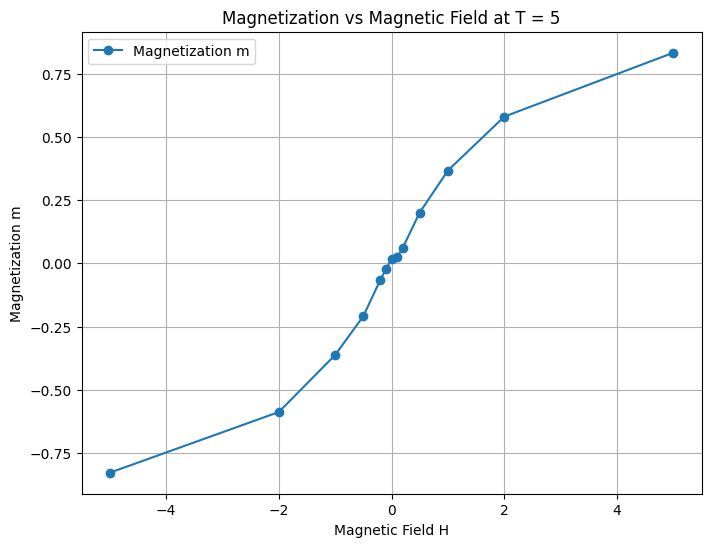

In [14]:
import random
import time

f = 0.05  # Number of randomly selected spins to flip-test.

num_iterations = 200

H_vals = [-5, -2, -1, -0.5, -0.2, -0.1, 0, 0.1, 0.2, 0.5, 1, 2, 5]
m_vals = []
Nspins = np.size(sl)  # Total number of spins in the spin lattice.
Ni, Nj = sl.shape

S = int(np.ceil(Nspins * f))  # Number of randomly selected spins.

for h in H_vals:
    m_tot = 0
    H = h
    sl = 2 * np.random.randint(2, size=(N, N)) - 1
    for i in range(num_iterations):
        ns = random.sample(range(Nspins), S)

        i_list = list(map(lambda x: x % Ni, ns)) 
        j_list = list(map(lambda x: x // Ni, ns)) 

        pi, Z = probabilities_spins(i_list, j_list, sl, H, J, T)

        rn = np.random.rand(S)
        for i in range(S):
            if rn[i] > pi[0, i]:
                sl[i_list[i], j_list[i]] = -1
            else:
                sl[i_list[i], j_list[i]] = 1
        m_tot += np.sum(sl) / (N**2)
    m_vals.append(m_tot / num_iterations)

# Plot m(H)
plt.figure(figsize=(8, 6))
plt.plot(H_vals, m_vals, 'o-', label="Magnetization m")
plt.xlabel("Magnetic Field H")
plt.ylabel("Magnetization m")
plt.title("Magnetization vs Magnetic Field at T = 5")
plt.legend()
plt.grid()
plt.show()





#### **Q1** - Calculate $\chi$.

In [16]:
from scipy.stats import linregress

# Use small H values for linear fit
small_H_indices = [i for i, H in enumerate(H_vals) if -0.5 <= H <= 0.5]
H_small = np.array([H_vals[i] for i in small_H_indices])
m_small = np.array([m_vals[i] for i in small_H_indices])

# Calculate slope (susceptibility)
slope, intercept, r_value, p_value, std_err = linregress(H_small, m_small)
chi = slope

print(f"Magnetic Susceptibility χ ≈ {chi}")

Magnetic Susceptibility χ ≈ 0.39206516666666663


#### **Task 2.** 
In this exercise we aim at finding the critical temperature of the Ising model by monitoring the
behavior of the absolute magnetization $\vert m \vert$ at $H = 0$ as a function of the temperature $T$. See reference figure
in the book Fig. 2.5. [Note: To obtain a figure like Fig. 2.5, you have to simulate for at least $10^5$ steps for each
value of the temperature, as explained in the book. In this task, we will use an alternative method that provides
a good first estimate of the critical temperature with significantly less iterations.]
Set the temperature $T$. We suggest you to use the following values for $T$:
$T = 0.1, 0.2, 0.5, 1, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3, 5.$
For each value of the temperature, start from a random state and perform 5000 iterations.
For the first 300 iterations, set $H = 0.1$.
For the remaining iterations, set $H = 0$.
After reaching the last iteration for a given $T$ , calculate the total magnetization of the system $m(T)$

##### **P2** - Plot $m(T)$

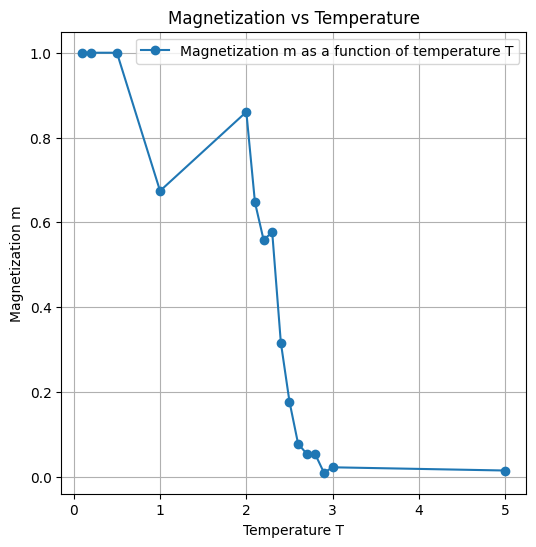

In [21]:
import random

f = 0.05  # Number of randomly selected spins to flip-test.

H = 0.1
num_iterations = 5000
T_vals = [0.1, 0.2, 0.5, 1, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3, 5]
m_vals = []
Nspins = np.size(sl)  # Total number of spins in the spin lattice.
Ni, Nj = sl.shape

S = int(np.ceil(Nspins * f))  # Number of randomly selected spins.

for t in T_vals:
    T = t
    H = 0.1
    sl = 2 * np.random.randint(2, size=(N, N)) - 1
    for i in range(num_iterations):
        if i == 300:
            H = 0
        
        ns = random.sample(range(Nspins), S)

        i_list = list(map(lambda x: x % Ni, ns)) 
        j_list = list(map(lambda x: x // Ni, ns)) 

        pi, Z = probabilities_spins(i_list, j_list, sl, H, J, T)

        rn = np.random.rand(S)
        for i in range(S):
            if rn[i] > pi[0, i]:
                sl[i_list[i], j_list[i]] = -1
            else:
                sl[i_list[i], j_list[i]] = 1
    
    m = np.sum(sl) / N**2
    m_vals.append(m)

# Plot m(H)
plt.figure(figsize=(6, 6))
plt.plot(T_vals, m_vals, 'o-', label="Magnetization m as a function of temperature T")
plt.xlabel("Temperature T")
plt.ylabel("Magnetization m")
plt.title("Magnetization vs Temperature for H = 0")
plt.legend()
plt.grid()
plt.show()



#### **Q2** - Estimate $T_c$ from your graph and explain your reasoning. Compare with theoretical value $T=2.269...$

For temperatures lower than $T_c$ we expect the magnetization to be higher as the spins align, on the other hand for temperatures higher than $T_c$ we expect the spins to be random and hence cancel each other out making the magnetization approach 0.
Therefore $T_c$ should be located where the system undergoes a phase transition from high magnetization to $\approx 0$ magnetization. In other words where the magnetization makes a steep drop to 0.

In our plot the steep drop seems start at $T=2.1$ and end around $T=2.5$, so $T_c \in [2.1,2.5]$, and perhaps it would make sense to think it is somewhere close to the middle of the interval so $T_c \approx 2.3$. Which is (surprisingly) a very good approximation based on the theoretical value considering the little work done here as opposed to in the text book.